Created by Alberto Ueda at 2017-01-09. Based on experiments of Sabir at 07-thesis.

In [24]:
N_AUTHORS = None

%pylab inline

import sys
sys.path.append('../../../../../ufmg-latin/pscore/rfs/')

import rfslib.datasets
dataset = rfslib.datasets.DBLPDataset('../../../../../pscore/datasets/',nauthors=N_AUTHORS)
dataset.prepare()

import rfslib.rankmodels
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [111]:
venuerank  = dataset.dfvenues.copy()
authorrank = dataset.dfauthors.copy()
grouprank  = dataset.dfgroups.copy()

In [112]:
import rfslib.pscorefactory
pscore = rfslib.pscorefactory.PScoreRankFactory(dataset,cpp=True,ranksize=1000,fullrank=True)

In [118]:
def run_pscore(params,venuerank,authorrank,grouprank,field):
    
    dranks = pscore.rank(params)
    vrank,arank,grank = dranks['venues'],dranks['authors'],dranks['groups']
    vscore,ascore,gscore = vrank['Score'],arank['Score'],grank['Score']

    rfslib.rankmodels.addscore(venuerank, vscore,field)
    rfslib.rankmodels.addscore(authorrank,ascore,field)
    rfslib.rankmodels.addscore(grouprank, gscore,field)
    
    return vrank,arank,grank

def head_ranks():    
    print vrank.head(), '\n\n', arank.head(), '\n\n', grank.head()

In [114]:
import rfslib.ndcg
def plot_ndcg_k(dfrank,features,relfield,namefield,N=25,n=1,filename=None,verbose=True):
    ks = range(1,1+N)
    dfndcg = pd.DataFrame(index=ks)
    xs = range(n,N+1,n)

    for feature in features:
        ranking = dfrank.sort_values(by=feature['name'],ascending=False)
        ranking = ranking.head(N) # uncomment to get only the head
        #ranking = ranking[~pd.isnull(ranking[feature['name']])] # uncomment to filter NAs
        ys = ranking[relfield].tolist()
        names = ranking[namefield].tolist()
        ndcg_at_k = [ rfslib.ndcg.get_ndcg(ys,k) for k in ks[:len(ys)] ]
        
        if not feature.has_key('label'):
            feature['label'] = feature['name']
        
        dfndcg[feature['label']] = pd.Series(ndcg_at_k,index=dfndcg.index[:len(ys)])

        if verbose == True:
            print 'FEATURE:',feature['name']
            print ['%i|%s' % (y,name) for (y,name) in zip(ys,names)],len(ys)
            print

    feature_labels  = [ f['label']  for f in features ]
    feature_styles = [ f['style'] for f in features ]
    ax = dfndcg.loc[xs,feature_labels].plot(lw = 1,grid=5,style=feature_styles)

    ax.minorticks_on()
    ax.set_xlabel("k")
    ax.set_ylabel("nDCG@k")
    ax.set_xlim((0,N+(N*0.03)))
    ax.set_ylim((0,1.05))
    
    if filename != None:
        savefig(filename)

## Ground Truth - Brazil CNPq Authors Productivity Levels

In [115]:
df = dataset.dfcnpqdblp.sort_index().drop_duplicates('Akey').reset_index().set_index('Akey') # drop duplicates
df = df.join(authorrank.reset_index().set_index('Akey'),rsuffix='_')
df = df.reset_index().set_index('CNPq_Id')
df = df.join(dataset.dfcnpq)
df['CNPq_Id'] = df.index
df = df.set_index('index')
df['CNPqLevelRel'] = pd.Series()
df['CNPqLevelRel'] = df['CNPqLevel'].replace({'1A':5,'1B':4,'1C':3,'1D':2,'2':1,np.nan:0})
df['CNPqLevelRel'].unique()

df = df.reset_index().set_index('CNPq_Id').sort_index()

cols_to_sum = df.columns.difference(dataset.dfcnpq.columns).difference([u'CNPqLevelRel', u'index'])
df2 = df.loc[:,cols_to_sum].groupby(level=0).sum()
df2 = df2.join(df.reset_index().drop_duplicates('CNPq_Id').set_index('CNPq_Id'),rsuffix='_')
print df2.columns.values
hide = ['index','Akey','APsize_','GS_Name','Begin','End','GS_Name.1','GS_Link']
df2.loc[:,df2.columns.difference(hide)]

df2.rename(columns={'GS_Cits':'Citations','GS_H5':'H-Index'},inplace=True)

authorrankbr = df2

rankauthors = sorted(authorrankbr['index'].dropna().map(int).values.tolist())

authorrankbr

['APsize' 'index' 'Akey' 'APsize_' 'Name' 'GS_Name' 'CNPqLevel' 'Begin'
 'End' 'University' 'GS_Name.1' 'GS_Link' 'GS_H5' 'GS_Cits' 'GS_H5_2010'
 'GS_Cits_2010' 'CNPqLevelRel']


,APsize,index,Akey,APsize_,Name,GS_Name,CNPqLevel,Begin,End,University,GS_Name.1,GS_Link,H-Index,Citations,GS_H5_2010,GS_Cits_2010,CNPqLevelRel
CNPq_Id,,,,,,,,,,,,,,,,,
0,33.0,45098.0,Abilio Lucena,33.0,Abilio Pereira de Lucena Filho,NaN,1C,01/03/14,28/02/2018,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,3
1,48.0,29497.0,Adenilso da Silva Simão,44.0,Adenilso da Silva Simão,Adenilso Simao,2,01/03/13,29/02/2016,USP,Adenilso Simao,/citations?user=gdT5wnMAAAAJ&hl=pt-BR,13.0,632.0,12.0,460.0,1
2,72.0,23509.0,Adriana Santarosa Vivacqua,53.0,Adriana Santarosa Vivacqua,NaN,2,01/03/13,29/02/2016,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,1
3,67.0,17464.0,Adriano Veloso,64.0,Adriano Alonso Veloso,Adriano Veloso,2,01/03/12,28/02/2015,UFMG,Adriano Veloso,/citations?user=j2BEVSoAAAAJ&hl=pt-BR,17.0,1003.0,16.0,716.0,1
4,78.0,20073.0,Adriano L. I. Oliveira,59.0,Adriano Lorena Inacio de Oliveira,Adriano L I Oliveira,2,01/03/13,29/02/2016,UFPE,Adriano L I Oliveira,/citations?user=paz29H4AAAAJ&hl=pt-BR,14.0,675.0,11.0,443.0,1
5,20.0,79915.0,Afonso Paiva,20.0,Afonso Paiva Neto,Afonso Paiva,2,01/03/14,28/02/2017,USP,Afonso Paiva,/citations?user=b7cto6oAAAAJ&hl=pt-BR,6.0,151.0,5.0,112.0,1
6,196.0,49669.0,Agma Juci Machado Traina,30.0,Agma Juci Machado Traina,Agma J. M. Traina,1B,01/03/14,28/02/2018,USP,Agma J. M. Traina,/citations?user=v2-C4i4AAAAJ&hl=pt-BR,26.0,3010.0,19.0,1566.0,4
7,75.0,14746.0,Alba Cristina Magalhaes Alves de Melo,72.0,Alba Cristina Magalhães Alves de Melo,Alba Cristina Magalhaes Alves de Melo,1D,01/03/11,28/02/2015,UNB,Alba Cristina Magalhaes Alves de Melo,/citations?user=vM_I8f4AAAAJ&hl=pt-BR,12.0,396.0,10.0,277.0,2
8,180.0,2171.0,Alberto H. F. Laender,180.0,Alberto Henrique Frade Laender,Alberto H. F. Laender,1A,01/03/14,28/02/2019,UFMG,Alberto H. F. Laender,/citations?user=HJhu4csAAAAJ&hl=pt-BR,29.0,3684.0,19.0,1678.0,5


# Computing Rankings

## Venues as sources

### Feature: Test

In [8]:
field = 'Test'
params = dict(area=1,
              model='P-score',
              year=(1940,2015),
              refvenues=[247], # SIGIR
              fullrank=True,
              rankauthors=rankauthors) 

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
#vrank.sort('Score',ascending=False)
#arank.sort('Score',ascending=False)
#grank.sort('Score',ascending=False)

../../../../../ufmg-latin/pscore/rfs/rfslib/rankmodels.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  return dfrank[~pd.isnull(dfrank[field])].sort(field,ascending=False)


### Feature: Venues - Top Venue of Sub-areas

In [126]:
field = 'Venues - Top Venue of Sub-areas'

vkeys = ['conf/stoc','conf/icra','conf/bmei','conf/fecs','conf/cvpr',
         'conf/kdd','conf/vldb','conf/icdcs','conf/siggraph','conf/dac',
         'conf/chi','conf/sigir','conf/nips','conf/spieSR','conf/icassp',
         'conf/infocom','conf/usenix','conf/popl','conf/cdc','conf/issac',
         'conf/crypto','conf/wsc','conf/icse','conf/www','journals/cacm']
refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in vkeys ]

params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

head_ranks()

            Vkey  VPsize  VPyear    Score
0  journals/corr     NaN     NaN      NaN
1       conf/ssp   361.0  2012.0   7818.0
2      conf/isit  4224.0  2008.0  45053.0
3  journals/tcom  7959.0  1989.0  79853.0
4   journals/twc  5728.0  2002.0  85526.0 

              Akey  APsize  Score
0  H. Vincent Poor     768    NaN
1         Wei Wang    1023    NaN
2        Yan Zhang     953    NaN
3          Wei Liu     934    NaN
4          Wen Gao     904    NaN 

                                         Name  NRC5  NRC95   Score
0                         Stanford University   1.0    2.0  1037.0
1           University of California-Berkeley   1.0    2.0  1010.0
2       Massachusetts Institute of Technology   3.0    5.0  1163.0
3                  Carnegie Mellon University   3.0   10.0   948.0
4  University of Illinois at Urbana-Champaign   3.0   18.0   869.0


### Feature: Venues - Top Venue of 1 Sub-area (JCDL)

In [132]:
field = 'Venues - Top Venue of 1 Sub-area'

vkeys = ['conf/sigir']
refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in vkeys ]

params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
print vrank.head(), arank.head(), grank.head()

            Vkey  VPsize  VPyear  Score
0  journals/corr     NaN     NaN    NaN
1       conf/ssp   361.0  2012.0   24.0
2      conf/isit  4224.0  2008.0  178.0
3  journals/tcom  7959.0  1989.0  513.0
4   journals/twc  5728.0  2002.0  643.0               Akey  APsize  Score
0  H. Vincent Poor     768    NaN
1         Wei Wang    1023    NaN
2        Yan Zhang     953    NaN
3          Wei Liu     934    NaN
4          Wen Gao     904    NaN                                          Name  NRC5  NRC95  Score
0                         Stanford University   1.0    2.0    8.0
1           University of California-Berkeley   1.0    2.0   13.0
2       Massachusetts Institute of Technology   3.0    5.0    7.0
3                  Carnegie Mellon University   3.0   10.0   24.0
4  University of Illinois at Urbana-Champaign   3.0   18.0   49.0


### Feature: Authors in Top Venues of Sub-areas

In [11]:
#field = 'Authors - in Top Venues of Sub-areas'
field = 'Top Venues of Sub-areas'

REFCOUNT  = 5

# Top 1 (50 venues)
#vkeys = ['conf/infocom', 'conf/icra', 'conf/icassp', 'conf/cvpr', 'conf/dac', 'conf/stoc', 'conf/vldb', 'conf/chi', 'conf/nips', 'conf/cdc', 'conf/siggraph', 'conf/spieSR', 'conf/icse', 'conf/sigir', 'conf/popl', 'conf/ismb', 'conf/kdd', 'conf/crypto', 'conf/www', 'conf/icdcs', 'conf/usenix', 'conf/wsc', 'conf/isit', 'conf/fecs', 'conf/issac']
#vkeys+= ['journals/tit', 'journals/pami', 'journals/cacm', 'journals/tsp', 'journals/tcom', 'journals/bioinformatics', 'journals/corr', 'journals/joc', 'journals/tsmc', 'journals/ai', 'journals/tse', 'journals/sigplan', 'journals/tcsv', 'journals/tog', 'journals/ijcv', 'journals/tkde', 'journals/ipl', 'journals/ipl', 'journals/dm', 'journals/sigops', 'journals/tpds', 'journals/internet', 'journals/jcal', 'journals/presence', 'journals/rts']

# Top 2 (100 venues)
#vkeys = ['conf/infocom', 'conf/mobicom', 'conf/icra', 'conf/ijcai', 'conf/icassp', 'conf/nips', 'conf/cvpr', 'conf/iccv', 'conf/dac', 'conf/iscas', 'conf/stoc', 'conf/focs', 'conf/vldb', 'conf/sigmod', 'conf/chi', 'conf/cscw', 'conf/nips', 'conf/icml', 'conf/cdc', 'conf/rtss', 'conf/siggraph', 'conf/visualization', 'conf/spieSR', 'conf/icip', 'conf/icse', 'conf/itc', 'conf/sigir', 'conf/cikm', 'conf/popl', 'conf/ecoop', 'conf/ismb', 'conf/recomb', 'conf/kdd', 'conf/icde', 'conf/crypto', 'conf/eurocrypt', 'conf/www', 'conf/iswc', 'conf/icdcs', 'conf/sc', 'conf/usenix', 'conf/sosp', 'conf/wsc', 'conf/mswim', 'conf/isit', 'conf/icip', 'conf/fecs', 'conf/aied', 'conf/issac', 'conf/iccs']
#vkeys+= ['journals/tit', 'journals/tcs', 'journals/pami', 'journals/pr', 'journals/cacm', 'journals/pieee', 'journals/tsp', 'journals/isci', 'journals/tcom', 'journals/jsac', 'journals/bioinformatics', 'journals/jcb', 'journals/corr', 'journals/siamcomp', 'journals/joc', 'journals/tissec', 'journals/tsmc', 'journals/cad', 'journals/ai', 'journals/fss', 'journals/tse', 'journals/dm', 'journals/sigplan', 'journals/toplas', 'journals/tcsv', 'journals/tmm', 'journals/tog', 'journals/cga', 'journals/ijcv', 'journals/cvgip', 'journals/tkde', 'journals/tods', 'journals/ipl', 'journals/tkde', 'journals/ipl', 'journals/isci', 'journals/dm', 'journals/ijmms', 'journals/sigops', 'journals/tpds', 'journals/tpds', 'journals/tocs', 'journals/internet', 'journals/firstmonday', 'journals/jcal', 'journals/ets', 'journals/presence', 'journals/simulation', 'journals/rts', 'journals/tecs']

# Top 4 (4*25=200 venues)
vkeys = ['conf/infocom', 'conf/mobicom', 'conf/icc', 'conf/vtc', 'conf/icra', 'conf/ijcai', 'conf/aaai', 'conf/icml', 'conf/icassp', 'conf/nips', 'conf/acl', 'conf/coling', 'conf/cvpr', 'conf/iccv', 'conf/eccv', 'conf/fgr', 'conf/dac', 'conf/iscas', 'conf/iccad', 'conf/ispd', 'conf/stoc', 'conf/focs', 'conf/soda', 'conf/icalp', 'conf/vldb', 'conf/sigmod', 'conf/icde', 'conf/hicss', 'conf/chi', 'conf/cscw', 'conf/uist', 'conf/iui', 'conf/nips', 'conf/icml', 'conf/iros', 'conf/isnn', 'conf/cdc', 'conf/rtss', 'conf/sensys', 'conf/ches', 'conf/siggraph', 'conf/visualization', 'conf/gi', 'conf/iv', 'conf/spieSR', 'conf/icip', 'conf/mm', 'conf/dcc', 'conf/icse', 'conf/itc', 'conf/cav', 'conf/sac', 'conf/sigir', 'conf/cikm', 'conf/trec', 'conf/jcdl', 'conf/popl', 'conf/ecoop', 'conf/pldi', 'conf/oopsla', 'conf/ismb', 'conf/recomb', 'conf/cbms', 'conf/eccb', 'conf/kdd', 'conf/icde', 'conf/cikm', 'conf/icdm', 'conf/crypto', 'conf/eurocrypt', 'conf/ccs', 'conf/asiacrypt', 'conf/www', 'conf/iswc', 'conf/icws', 'conf/usits', 'conf/icdcs', 'conf/sc', 'conf/podc', 'conf/icpp', 'conf/usenix', 'conf/sosp', 'conf/osdi', 'conf/nossdav', 'conf/wsc', 'conf/mswim', 'conf/pads', 'conf/anss', 'conf/isit', 'conf/icip', 'conf/wcnc', 'conf/or', 'conf/fecs', 'conf/aied', 'conf/sigcse', 'conf/its', 'conf/issac', 'conf/iccs', 'conf/ppsc', 'conf/aisc']
vkeys+= ['journals/tit', 'journals/tcs', 'journals/siamcomp', 'journals/iandc', 'journals/pami', 'journals/pr', 'journals/neco', 'journals/ml', 'journals/cacm', 'journals/pieee', 'journals/tc', 'journals/jacm', 'journals/tsp', 'journals/isci', 'journals/taslp', 'journals/bsl', 'journals/tcom', 'journals/jsac', 'journals/ccr', 'journals/ton', 'journals/bioinformatics', 'journals/jcb', 'journals/bib', 'journals/cmpb', 'journals/corr', 'journals/siamcomp', 'journals/jcss', 'journals/amc', 'journals/joc', 'journals/tissec', 'journals/compsec', 'journals/dcc', 'journals/tsmc', 'journals/cad', 'journals/vlsi', 'journals/micro', 'journals/ai', 'journals/fss', 'journals/ijrr', 'journals/tfs', 'journals/tse', 'journals/dm', 'journals/jct', 'journals/software', 'journals/sigplan', 'journals/toplas', 'journals/scp', 'journals/jlp', 'journals/tcsv', 'journals/tmm', 'journals/mms', 'journals/ieeemm', 'journals/tog', 'journals/cga', 'journals/cgf', 'journals/tvcg', 'journals/ijcv', 'journals/cvgip', 'journals/cviu', 'journals/ivc', 'journals/tkde', 'journals/tods', 'journals/isr', 'journals/is', 'journals/ipl', 'journals/tkde', 'journals/datamine', 'journals/vldb', 'journals/ipl', 'journals/isci', 'journals/jasis', 'journals/tois', 'journals/dm', 'journals/ijmms', 'journals/rsa', 'journals/tochi', 'journals/sigops', 'journals/tpds', 'journals/tocs', 'journals/sigmetrics', 'journals/tpds', 'journals/tocs', 'journals/jpdc', 'journals/pc', 'journals/internet', 'journals/firstmonday', 'journals/www', 'journals/isj', 'journals/jcal', 'journals/ets', 'journals/ijlt', 'journals/tlt', 'journals/presence', 'journals/simulation', 'journals/tomacs', 'journals/jirs', 'journals/rts', 'journals/tecs', 'journals/jnsm', 'journals/jcsc']

refauthors = []

for vkey in vkeys:
    vid  = dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0]

    authorrank_ = dataset.dfauthors.copy()

    authorrank_[vkey] = dataset.df[dataset.df.VID==vid].groupby(level=0).PID.count()
    df_ = authorrank_[~pd.isnull(authorrank_[vkey])]
    refauthors += list(df_.sort_values(by=vkey,ascending=False).index[:REFCOUNT].values)
    df_.sort_values(by=vkey,ascending=False)
    
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)
    
vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
vrank

,Vkey,VPsize,VPyear,Score
0,journals/corr,NaN,NaN,NaN
1,conf/ssp,361.0,2012.0,20.0
2,conf/isit,4224.0,2008.0,393.0
3,journals/tcom,7959.0,1989.0,808.0
4,journals/twc,5728.0,2002.0,724.0
5,journals/jstsp,733.0,2008.0,68.0
6,conf/acssc,1721.0,2011.0,91.0
7,journals/tmc,1549.0,2002.0,209.0
8,journals/tit,13667.0,1953.0,1197.0
9,journals/wc,1264.0,1994.0,115.0


## Authors as sources

### Feature: Authors - Turing Awards

In [12]:
field = 'Authors - Turing Awards'

refauthors = [3009,561,3456,2955,867,5310,180603,4092,491,2249,5089,85727,40374,94458,9492,76749,1671,22367,1208,148014,121082,3046,14315,79567,133714,570,12400,34707,40223,5146,14258,14355,6551,142367,77788,50407,65485,4651,477,945,10763,116937,192122,5457,22493,3835,67596,38875,213417,32299,16382] 
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

### Feature: Authors - Most Cited

In [13]:
field = 'Most Cited Authors'

refcandidates = pd.read_csv('../data/Author_Cit.csv',index_col=0)
_df = refcandidates.loc[refcandidates.Year==2015].sort_values(by='Score',ascending=False)

refauthors = _df.head(1000).index.tolist()
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
vrank

,Vkey,VPsize,VPyear,Score
0,journals/corr,NaN,NaN,NaN
1,conf/ssp,361.0,2012.0,23.0
2,conf/isit,4224.0,2008.0,430.0
3,journals/tcom,7959.0,1989.0,670.0
4,journals/twc,5728.0,2002.0,639.0
5,journals/jstsp,733.0,2008.0,72.0
6,conf/acssc,1721.0,2011.0,107.0
7,journals/tmc,1549.0,2002.0,293.0
8,journals/tit,13667.0,1953.0,1358.0
9,journals/wc,1264.0,1994.0,114.0


## Groups as sources

### Feature: Groups - NRC Top 10

In [14]:
field = 'Groups - NRC Top 10'

params = dict(area=1,model='P-score',year=(1940,2015),refgroups=range(10),rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

In [106]:
print arank[arank.Akey=='Nivio Ziviani']
#dataset.df[dataset.df.Akey=='Nivio Ziviani']
print vrank[vrank.Vkey=='conf/kdd']

#vkeys = ['conf/kdd']

#dataset.df.reset_index().set_index('VID').loc[75].reset_index().set_index('AID')

               Akey  APsize  Score
7054  Nivio Ziviani     103    NaN
        Vkey  VPsize  VPyear  Score
75  conf/kdd  2869.0  1994.0  116.0


### Feature: Groups - NRC 126

In [16]:
field = '126 Groups NRC'

params = dict(area=1,model='P-score',year=(1940,2015),refgroups=range(126),rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

### Feature: Groups - Rand. 12

In [17]:
field = '12 Groups RandProc'

params = dict(area=1,model='P-score',year=(1940,2015),refgroups=[
0, # Stanford University
1, # University of California-Berkeley
2, # Massachusetts Institute of Technology
3, # Carnegie Mellon University
4, # University of Illinois at Urbana-Champaign
6, # Cornell University    
9, # University of California-Los Angeles
11, # Georgia Institute of Technology
13, # University of Maryland College Park
14, # University of California-San Diego
15, # University of Michigan-Ann Arbor
16, # University of Southern California
],rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

# Thesis Results and Visualization

In [129]:
common_features = [
    #dict(name='Groups - NRC Top 10',style='r-o'),
    dict(name='126 Groups NRC',style='k-'),
    dict(name='12 Groups RandProc',style='k-o'),
    dict(name='Most Cited Authors',style='r-+'),
    #dict(name='Authors - in Top Venues of Sub-areas',style='g-x'),
    #dict(name='Authors - Turing Awards',style='b-+'),
    #dict(name='Venues - Top Venue of Sub-areas',style='r-*'),
    dict(name='Top Venues of Sub-areas',style='r-*'),
    dict(name='Venues - Top Venue of 1 Sub-area',style='r-*'),
]

## Venue graphs

In [130]:
# bkp 
# import venue.qualis
#from venue.qualis import qualis

sys.path.append('venue/qualis/')
from qualis import qualis
# import qualis 

# Ground Truth
venuerank['Qualis'] = venuerank.Vkey.map(lambda vkey: qualis.get_qualis_dblp('dblp:'+vkey))
venuerank['QualisRel'] = pd.Series()
venuerank['QualisRel'] = venuerank['Qualis'].replace(
    {'A1':7,'A2':6,'B1':5,'B2':4,'B3':3,'B4':2,'B5':1,'C ':0,np.nan:0})
venuerank['QualisRel'].unique()

array([0, 5, 7, 6, 3, 4, 2, 1])

In [133]:
# Baseline

dfgsvenues = pd.read_csv('../data/dblp-gs-venues.csv',index_col=0)
dfgsvenues.rename(columns={'GSHindex':'H-Index'},inplace=True)
if 'H-Index' in venuerank.columns:
    del venuerank['H-Index']
venuerank = venuerank.reset_index().set_index('Vkey').join(dfgsvenues['H-Index']).reset_index().set_index('index')
venuerank.sort_values(by='H-Index',ascending=False)

,Vkey,VPsize,VPyear,Venues - Top Venue of Sub-areas,Venues - Top Venue of 1 Sub-area,Qualis,QualisRel,H-Index
index,,,,,,,,
5763,journals/nature,1.0,2007.0,NaN,NaN,None,0,355.0
5718,journals/science,1.0,1983.0,6.0,NaN,None,0,311.0
587,journals/nar,5753.0,1975.0,13093.0,503.0,B1,5,164.0
4714,conf/and,32.0,2009.0,216.0,57.0,None,0,162.0
5246,conf/sci,28.0,1999.0,21.0,NaN,None,0,136.0
4281,conf/balt,232.0,1991.0,238.0,5.0,None,0,132.0
5320,conf/b,53.0,1998.0,25.0,NaN,None,0,128.0
273,journals/cma,4572.0,2006.0,8117.0,334.0,None,0,118.0
194,conf/cvpr,6874.0,1993.0,286078.0,3183.0,A1,7,118.0


In [53]:
# Baseline cits

import pandas as pd
vkey_cits = pd.read_csv('../data/vkey_cits.csv',index_col=0,names=['Vkey','Vcits']) # TODO by year
venuerank = venuerank.reset_index().set_index('Vkey')
venuerank['Citations'] = vkey_cits['Vcits']
venuerank = venuerank.reset_index().set_index('index')
venuerank

,Vkey,VPsize,VPyear,Test,Venues - Top Venue of Sub-areas,Top Venues of Sub-areas,Authors - Turing Awards,Most Cited Authors,Groups - NRC Top 10,126 Groups NRC,12 Groups RandProc,Qualis,QualisRel,H-Index,Citations
index,,,,,,,,,,,,,,,
0,journals/corr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,NaN,485635.0
1,conf/ssp,361.0,2012.0,24.0,7818.0,20.0,NaN,23.0,2.0,21.0,6.0,None,0,NaN,94.0
2,conf/isit,4224.0,2008.0,178.0,45053.0,393.0,28.0,430.0,88.0,320.0,116.0,B1,5,49.0,15815.0
3,journals/tcom,7959.0,1989.0,513.0,79853.0,808.0,6.0,670.0,44.0,255.0,42.0,A1,7,NaN,236070.0
4,journals/twc,5728.0,2002.0,643.0,85526.0,724.0,9.0,639.0,29.0,265.0,26.0,A1,7,NaN,84604.0
5,journals/jstsp,733.0,2008.0,75.0,22634.0,68.0,1.0,72.0,10.0,49.0,18.0,A1,7,NaN,6282.0
6,conf/acssc,1721.0,2011.0,80.0,34925.0,91.0,1.0,107.0,16.0,79.0,20.0,None,0,26.0,458.0
7,journals/tmc,1549.0,2002.0,246.0,35058.0,209.0,4.0,293.0,57.0,418.0,105.0,None,0,NaN,38787.0
8,journals/tit,13667.0,1953.0,525.0,121840.0,1197.0,31.0,1358.0,298.0,1003.0,402.0,A1,7,NaN,729338.0


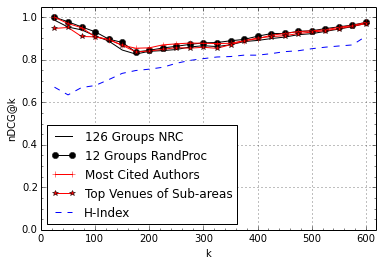

In [60]:
features  = list(common_features)
#features = filter(lambda x: x['name'].split()[0] == 'Venues',features)
baselines = [    
    #dict(name='Citations',style='k--'), # MAG Approx.
    dict(name='H-Index',style='b--'), #
]

N  = 600
n  = 25

dfrank    = venuerank
relfield  = 'QualisRel'
namefield = 'Vkey'

dfrank = dfrank[dfrank[relfield]>0] # filter: only venues evaluated in CS Qualis

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_v.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Venue => Venue

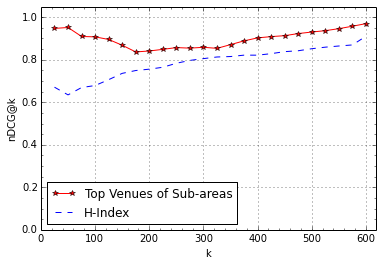

In [61]:
features_ = filter(lambda x: 'Venue' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_vfromv.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Author => Venue

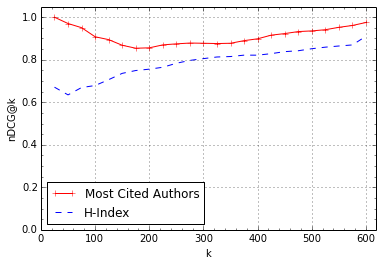

In [62]:
features_ = filter(lambda x: 'Author' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_vfroma.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Group => Venue

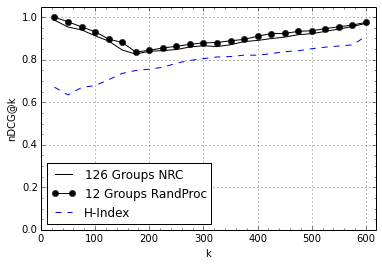

In [63]:
features_ = filter(lambda x: 'Group' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_vfromg.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Author graphs

In [107]:
# Ground Truth - Brazil
df = dataset.dfcnpqdblp.sort_index().drop_duplicates('Akey').reset_index().set_index('Akey') # drop duplicates
df = df.join(authorrank.reset_index().set_index('Akey'),rsuffix='_')
df = df.reset_index().set_index('CNPq_Id')
df = df.join(dataset.dfcnpq)
df['CNPq_Id'] = df.index
df = df.set_index('index')
df['CNPqLevelRel'] = pd.Series()
df['CNPqLevelRel'] = df['CNPqLevel'].replace({'1A':5,'1B':4,'1C':3,'1D':2,'2':1,np.nan:0})
df['CNPqLevelRel'].unique()

df = df.reset_index().set_index('CNPq_Id').sort_index()

cols_to_sum = df.columns.difference(dataset.dfcnpq.columns).difference([u'CNPqLevelRel', u'index'])
df2 = df.loc[:,cols_to_sum].groupby(level=0).sum()
df2 = df2.join(df.reset_index().drop_duplicates('CNPq_Id').set_index('CNPq_Id'),rsuffix='_')
print df2.columns.values
hide = ['index','Akey','APsize_','GS_Name','Begin','End','GS_Name.1','GS_Link']
df2.loc[:,df2.columns.difference(hide)]

df2.rename(columns={'GS_Cits':'Citations','GS_H5':'H-Index'},inplace=True)

authorrankbr = df2

rankauthors = sorted(authorrankbr['index'].dropna().map(int).values.tolist())

authorrankbr.head()

['12 Groups RandProc' '126 Groups NRC' 'APsize' 'Authors - Turing Awards'
 'Groups - NRC Top 10' 'Most Cited Authors' 'Test'
 'Top Venues of Sub-areas' 'Venues - Top Venue of Sub-areas' 'index' 'Akey'
 'APsize_' 'Test_' 'Venues - Top Venue of Sub-areas_'
 'Top Venues of Sub-areas_' 'Authors - Turing Awards_'
 'Most Cited Authors_' 'Groups - NRC Top 10_' '126 Groups NRC_'
 '12 Groups RandProc_' 'Name' 'GS_Name' 'CNPqLevel' 'Begin' 'End'
 'University' 'GS_Name.1' 'GS_Link' 'GS_H5' 'GS_Cits' 'GS_H5_2010'
 'GS_Cits_2010' 'CNPqLevelRel']


,12 Groups RandProc,126 Groups NRC,APsize,Authors - Turing Awards,Groups - NRC Top 10,Most Cited Authors,Test,Top Venues of Sub-areas,Venues - Top Venue of Sub-areas,index,...,Begin,End,University,GS_Name.1,GS_Link,H-Index,Citations,GS_H5_2010,GS_Cits_2010,CNPqLevelRel
CNPq_Id,,,,,,,,,,,,,,,,,,,,,
0,990.0,4492.0,33.0,80.0,798.0,4433.0,NaN,3022.0,NaN,45098.0,...,01/03/14,28/02/2018,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,3
1,1492.0,6834.0,48.0,50.0,1046.0,3088.0,NaN,2488.0,NaN,29497.0,...,01/03/13,29/02/2016,USP,Adenilso Simao,/citations?user=gdT5wnMAAAAJ&hl=pt-BR,13.0,632.0,12.0,460.0,1
2,2229.0,6729.0,72.0,618.0,1204.0,4623.0,NaN,3717.0,NaN,23509.0,...,01/03/13,29/02/2016,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4738.0,16860.0,67.0,378.0,3254.0,14661.0,3.0,11864.0,NaN,17464.0,...,01/03/12,28/02/2015,UFMG,Adriano Veloso,/citations?user=j2BEVSoAAAAJ&hl=pt-BR,17.0,1003.0,16.0,716.0,1
4,1301.0,9920.0,78.0,570.0,884.0,6175.0,NaN,5051.0,NaN,20073.0,...,01/03/13,29/02/2016,UFPE,Adriano L I Oliveira,/citations?user=paz29H4AAAAJ&hl=pt-BR,14.0,675.0,11.0,443.0,1


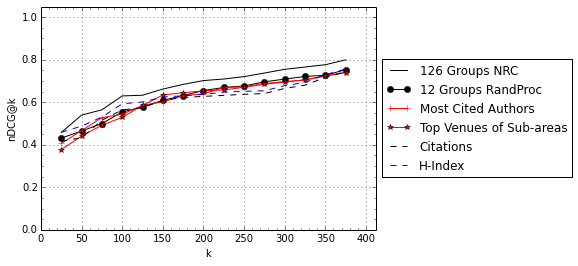

In [108]:
features = list(common_features)
#features = filter(lambda x: x['name'].split()[0] == 'Groups',features)
baselines= [    
    dict(name='Citations',style='k--'),
    dict(name='H-Index',style='b--'),
]

N  = 400
n  = 25

dfrank    = authorrankbr
relfield  = 'CNPqLevelRel'
namefield = 'Akey'

dfrank = dfrank[dfrank[relfield]>0] # filter: only venues evaluated in CNPq
#dfrank = dfrank.dropna()

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_a.eps')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Venue => Author (JCDL)

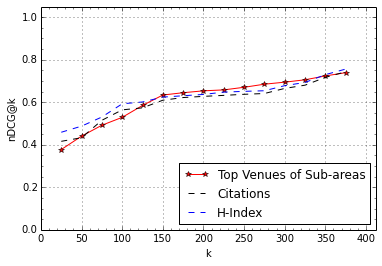

In [99]:
features_ = filter(lambda x: 'Venue' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_afromv.eps')
plt.legend(loc='lower right')
#dfrank.sort_values(by='Top Venues of Sub-areas',ascending=False)

### Author => Author

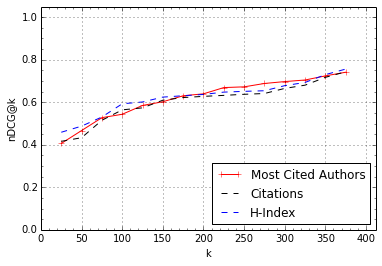

In [67]:
features_ = filter(lambda x: 'Author' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_afroma.eps')
plt.legend(loc='lower right')

### Group => Author

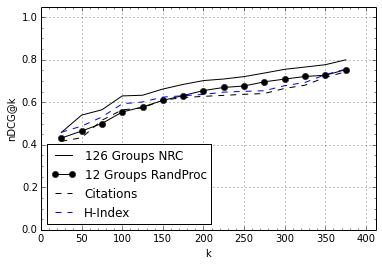

In [68]:
features_ = filter(lambda x: 'Group' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_afromg.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Group graphs

In [69]:
# Ground Truth

br_group_ids = range(126,151)
grouprankbr = grouprank.loc[br_group_ids]
#print '\n'.join(grouprankbr.Name.values)
grouprankbr

dfcapes = pd.read_csv('../data/capes_cs.csv',index_col='Name')
dfcapes

grouprankbr = grouprankbr.reset_index().set_index('Name').join(dfcapes).reset_index().set_index('index')
grouprankbr.Capes2013.unique()

array([4, 6, 5, 7])

In [70]:
# Baseline
import pandas as pd
group_cits = pd.read_csv('../data/groupbr_cits.csv',index_col=0,names=['GID','Gcits'])
group_cits
grouprankbr['Citations'] = group_cits['Gcits']

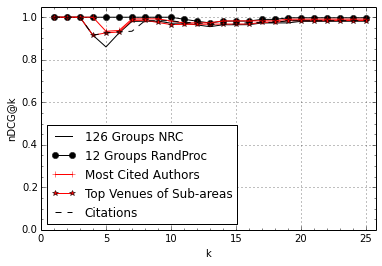

In [71]:
features = list(common_features)
baselines= [
    dict(name='Citations',style='k--'),
]

N  = 25
n  = 1

dfrank    = grouprankbr
relfield  = 'Capes2013'
namefield = 'ShortName'

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_g.eps')

### Venue => Group

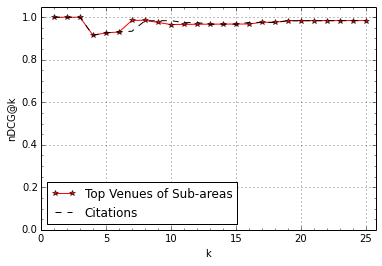

In [72]:
features_ = filter(lambda x: 'Venue' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_gfromv.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Author => Group

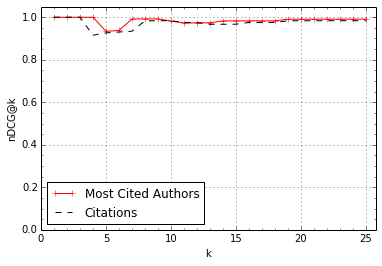

In [73]:
features_ = filter(lambda x: 'Author' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_gfroma.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Group => Group

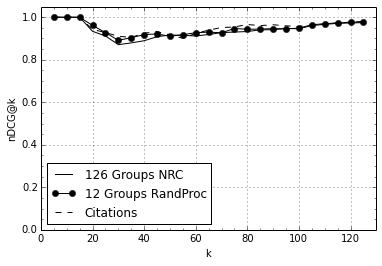

In [79]:
features_ = filter(lambda x: 'Group' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_gfromg.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### NRC as Ground Truth

In [75]:
# Citations baseline

dfcits = pd.read_csv('../data/05-jcdl-2016/dfPcits.csv',header=None)
dfcits.columns = ['Pkey','Citations']
dfcits.set_index('Pkey',inplace=True)

dfgrouppapercits = pd.merge(dataset.dfgrouppaper,dfcits,
                            left_on='Pkey',right_index=True,how='left')

grouprank['Citations'] = dfgrouppapercits.groupby(level=0).Citations.sum()

In [76]:
#print grouprank.NRC5.max()
RelNRC = grouprank.NRC5.dropna()

RelNRC[RelNRC <= 20] = 1000 + 3
RelNRC[RelNRC <= 40] = 1000 + 2
RelNRC[RelNRC <= 80] = 1000 + 1
RelNRC[RelNRC <= grouprank.NRC5.max()]= 1000 + 0
RelNRC -= 1000

#RelNRC = RelNRC.max() - RelNRC + 1

grouprank['RelNRC'] = RelNRC
#grouprank

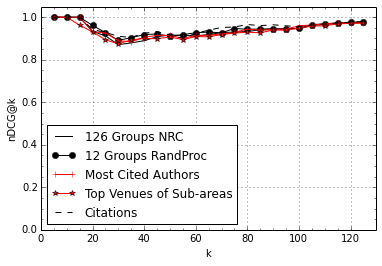

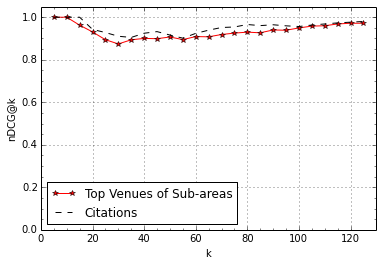

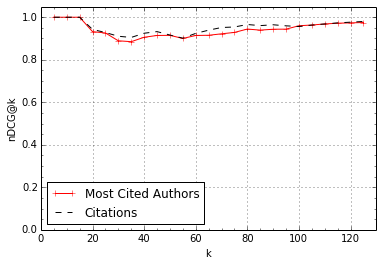

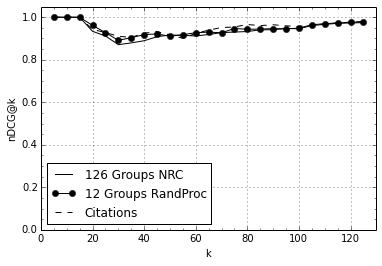

In [81]:
N  = 126
n  = 5

dfrank    = grouprank[~pd.isnull(grouprank['NRC5'])]
relfield  = 'RelNRC'
namefield = 'Name'

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_g_NRC.eps')
#+baselines
#plot_ndcg_k(dfrank,features,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_g_NRC.eps')
#dfrank.head(50)

features_ = filter(lambda x: 'Venue' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_rank_gfromv_NRC.eps')

features_ = filter(lambda x: 'Author' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_rank_gfroma_NRC.eps')

features_ = filter(lambda x: 'Group' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_rank_gfromg_NRC.eps')

# Experiments for the Journal Paper

In [203]:
'''features = [

    dict(name='Groups - NRC Top 10',style='r-o',label='P-score 10'),
    dict(name='Groups - NRC 126',style='k-',label='P-score 126'),
    
    dict(name='Citations',style='k-*',label='Citations'),
]

N  = 25
n  = 1

dfrank    = grouprankbr
relfield  = 'Capes2013'
namefield = 'ShortName'

plot_ndcg_k(dfrank,features,relfield,namefield,N=N,n=n,filename='figs/ndcg-groups-nrc.eps')'''
pass

In [ ]:
x, y = 'Groups - RandProc 12', 'Citations'
df = venuerank

df[x] = df[x] / df[x].max()

ax = df.plot(kind='scatter',x=x,y=y,logx=True,logy=True,alpha=0.2)
ax.grid(5)
ax.minorticks_on()
ax.set_xlim((0,1))
ax.set_ylim((0,None))
ax.set_xlabel('P-score')
ax.set_ylabel('Citations')
print df.loc[:,[x,y]].count()
print df.loc[:,[x,y]].corr('kendall')
savefig('figs/pscore-citation-venue.eps')
savefig('figs/pscore-citation-venue.png')

In [ ]:
x, y = 'Groups - NRC Top 10', 'Citations'
df   = authorrankbr 

ax = df.plot(kind='scatter',x=x,y=y,logx=True,logy=True,alpha=0.4)
ax.set_xlim((0,None))
ax.set_ylim((0,None))
ax.set_ylabel('Citations')
print df.loc[:,[x,y]].count()
df.loc[:,[x,y]].corr('kendall')

In [ ]:
#field = 'Groups - NRC Top 10'
#venuerank.sort(field,ascending=False).head(100)
#authorrankbr[~pd.isnull(authorrankbr[field])]
authorrankbr.shape

In [ ]:
x, y = 'Groups - NRC Top 10', 'Citations'
df   = grouprankbr

df[x] = df[x] / df[x].max()

ax = df.plot(kind='scatter',x=x,y=y,logx=False,logy=False,alpha=1)
ax.grid(5)
ax.minorticks_on()
ax.set_xlim((0,1))
ax.set_ylim((0,None))
ax.set_xlabel('P-score')
ax.set_ylabel('Citations')
print df.loc[:,[x,y]].count()
print df.loc[:,[x,y]].corr('kendall')
savefig('figs/pscore-citation-groupbr.eps')
savefig('figs/pscore-citation-groupbr.png')

In [ ]:
df = venuerank

plt.figure()
field = 'QualisRel'
bp = df[df[field]<=6].loc[:,[y,field]].boxplot(by=field)
bp.set_ylim((0,30000))

plt.figure()
field = 'QualisRel'
bp = df[df[field]<=6].loc[:,[x,field]].boxplot(by=field)
bp.set_ylim((0,.06))

In [ ]:
df[y+"_rank"]=(-df[y]).rank()

plt.figure()
field = 'QualisRel'
bp = df[df[field]<=7].loc[:,[y+"_rank",field]].boxplot(by=field)
#bp.set_ylim((0,30000))

df[x+"_rank"]=(-df[x]).rank()

plt.figure()
field = 'QualisRel'
bp = df[df[field]<=7].loc[:,[x+"_rank",field]].boxplot(by=field)
#bp.set_ylim((0,30000))

# Recall Analysis

In [ ]:
def make_ranges(N=10,K=3):
    index_0i = [ range(i+1) for i in range(N) ]
    index_iN = [ range(i,N) for i in range(N) ]
    index_K = [ range(i,i+K) for i in range(N-K+1) ]
    return index_0i,index_iN,index_K

index_0i,index_iN,index_K = make_ranges(N=10,K=3)

In [ ]:
index_0i

In [ ]:
index_iN

In [ ]:
index_K

In [ ]:
dfvenues = dataset.dfvenues.sort(['VPsize','Vkey'],ascending=[False,True])
dfvenues = dfvenues[dfvenues.Vkey.map(lambda k: k.split('/')[0] in ['conf','journals'])]
dfvenues = dfvenues[dfvenues.index!=0]

dfvenues = dfvenues.join(venuerank['Citations'])
dfvenues = dfvenues.join(venuerank['H-Index'])

index_0i,index_iN,index_K = make_ranges(N=dfvenues.shape[0],K=10)
#dfvenues.iloc[vids_K[1]].index.tolist()

dfvenues

In [ ]:
index = index_K[1]
dfvenues.iloc[index].index.tolist()

## Ranking Venues

In [ ]:
venuerankclean = dfvenues
n_total = venuerankclean.shape[0]

#print venuerankclean['Citations'].count() # não usar citations pois vem do MAG
print venuerankclean['H-Index'].count()

print n_total

### Venues as sources

In [ ]:
'''for index in index_0i:
    sourceids = dfvenues.iloc[index].index.tolist()
    print len(sourceids),sourceids,
    
#    break
#if True:
    
    field = 'Test'
    params = dict(area=1,model='P-score',year=(1940,2015),refvenues=sourceids)
    
    while True:
        try:
            vrank,arank,grank = run_pscore(params,venuerankclean,authorrank,grouprank,field)
            break
        except:
            print 'fail'
            pass
    
    #vrank[~pd.isnull(vrank.Score)].Vkey.map(lambda k: not k[0] in 'cj').value_counts()
    
    n_ranked = vrank[~pd.isnull(vrank.Score)].shape[0]
    
    recall = n_ranked / float(n_total)
    
    print recall,n_ranked,n_total
    
    if len(sourceids)==10:break
'''
pass

In [ ]:
venuerankclean.columns

- An author being cited means that his venue is cited.
- A venue being cited does not mean that an author is cited.

- The distributions tend to be a long tail.
- We can base our reputation model in the heads only.